In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import scipy as sp # type: ignore
from scipy.optimize import curve_fit # type: ignore
import matplotlib.pyplot as plt # type: ignore

#Functional API
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras.models import Model # type: ignore
import keras.optimizers # type: ignore
from keras.layers import Dense, Input # type: ignore

# UNITS
ev2au = 1/27.211396132
au2ev = 27.211396132
ang2au = 1/0.529177249
au2ang = 0.529177249
au2fs = 1/41.34137333656
fs2au = 41.34137333656
au2debye = 1/0.39343
debye2au = 0.39343
au2nm = 0.052917720859
nm2au = 1/0.052917720859
au2cm1 = 2.1947463137E5
cm12au = 1/(2.1947463137E5)
au2amu = 1/1822.88848325
amu2au = 1822.88848325
thz2au = 1.0/0.029979/au2cm1

2025-05-24 16:33:48.497457: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 16:33:48.502579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-24 16:33:48.517872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748118828.542739   92670 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748118828.553485   92670 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#La suma debe ser una suma de 32 terminos

coeff_matrix = np.zeros((32,4))
coeff_matrix[0,:] = [0,0,1,32849.58]
coeff_matrix[1,:] = [0,1,1,-17553.99]
coeff_matrix[2,:] = [1,0,1,-27625.23]
coeff_matrix[3,:] = [2,0,0,50043.09]
coeff_matrix[4,:] = [4,0,0,336.49]
coeff_matrix[5,:] = [0,1,2,-3360.94]
coeff_matrix[6,:] = [0,3,0,-64.84]
coeff_matrix[7,:] = [1,1,1,18285.40]
coeff_matrix[8,:] = [2,0,1,-7181.44]
coeff_matrix[9,:] = [0,0,4,2553.25]
coeff_matrix[10,:] = [0,2,2,-4905.39]
coeff_matrix[11,:] = [0,4,0,3505.21]
coeff_matrix[12,:] = [1,1,2,-21845.86]
coeff_matrix[13,:] = [1,3,0,-1416.44]
coeff_matrix[14,:] = [2,1,1,5596.86]
coeff_matrix[15,:] = [3,0,1,-142.39]
coeff_matrix[16,:] = [0,0,2,15623.64]
coeff_matrix[17,:] = [0,2,0,72972.84]
coeff_matrix[18,:] = [1,1,0,9857.17]
coeff_matrix[19,:] = [3,0,0,-2376.30]
coeff_matrix[20,:] = [0,2,1,-8550.95]
coeff_matrix[21,:] = [1,0,2,-4597.25]
coeff_matrix[22,:] = [1,2,0,-657.28]
coeff_matrix[23,:] = [2,1,0,1985.36]
coeff_matrix[24,:] = [0,1,3,-5546.12]
coeff_matrix[25,:] = [0,3,1,-11098.50]
coeff_matrix[26,:] = [1,0,3,-9178.03]
coeff_matrix[27,:] = [1,2,1,948.74]
coeff_matrix[28,:] = [2,0,2,-983.04]
coeff_matrix[29,:] = [2,2,0,-584.78]
coeff_matrix[30,:] = [3,1,0,1694.77]
coeff_matrix[31,:] = [0,0,3,4971.79]

def V(R1,R2,theta):
    R1e = 1.5614*ang2au #Amstrong C-S bond; R1e: Equilibrium value of R1
    R2e = 1.1562*ang2au #Amstrong C-O bond; R2e: Equilibrium value of R2
    alpha_1 = 1.95/ang2au #Amstrong^-1
    alpha_2 = 2.34/ang2au #Amstrong^-1
    theta_e = np.pi #Degrees

    aR1 = -alpha_1*(R1-R1e)
    aR2 = -alpha_2*(R2-R2e)

    y_1 = 1.0 - np.exp(aR1)
    y_2 = 1.0 - np.exp(aR2)
    y_3 = np.cos(theta) - np.cos(theta_e)

    suma = 0.0
    for i in range(32):
        suma = suma + (coeff_matrix[i,3]*cm12au)*(y_1**int(coeff_matrix[i,0]))*(y_2**int(coeff_matrix[i,1]))*(y_3**(coeff_matrix[i,2]))


    return(suma)

In [3]:
q1 = np.concatenate((np.linspace(1.45,5.0,20),np.linspace(5.0, 8, 7))) #Azul
q2 = np.concatenate((np.linspace(1.6,5.0,20),np.linspace(5.0, 8, 7))) #Naranja
R1e_values = np.linspace(2.1, 5, 29)
R2e_values = np.linspace(1.8, 4, 29) 
R1e, R2e = np.meshgrid(R1e_values, R2e_values)
theta_eq = np.pi
energia_superficie = np.vectorize(V)(R1e, R2e, np.pi) #np.vectorize para aplicar la función a matrices

In [4]:
# Generacion del archivo de datos
data_set = np.zeros((len(q1)**2,3)) #Dim(729,3)
l = 0 #Inicializa en 0
for i in range(len(q1)): #R1
    for j in range(len(q2)): #R2
        data_set[l,:] = q1[i],q2[j],V(q1[i],q2[j],np.pi) #Obtenemos valores para R1, R2 y V(R1,R2)
        l = l + 1

df = pd.DataFrame(data_set)
df.to_csv('PotencialOCS_2.csv')
df.columns = ['R1','R2','V'] #Renombramos las columnas

In [5]:
inputsmodel = df.drop('V', axis=1)
#inputsmodel

#Dejamos los valores de V como targets
target = df.iloc[:,-1]
#target

In [6]:
#Creamos una funcion custom_loss incluyendo la perdida fisica de la pinn.
from scipy.optimize import curve_fit # type: ignore

def morsepotential(q, D, alpha, E0, R_eq):
    return D*(1.0 - np.exp(-alpha*(q-R_eq)))**2 + E0

xdata = np.concatenate((np.linspace(1.6,5.0,30),np.linspace(5.0, 8, 7))) #q2
morse_parameters = np.zeros((len(q1),5))

for i in range(len(q1)): #En este range cambio la forma de graficar
    ydata = V(q1[i],xdata,theta_eq) #Potencial segun xdata
    popt, pcov = curve_fit(morsepotential, xdata, ydata, p0=[3.49440974e-01,  1.22952512e+00, -1.73828756e-03    ,  2.18903764e+00]) #Se hace el fitting considerando un p0 inicial para el resto
    
    morse_parameters[i,0] = q1[i]
    morse_parameters[i,1:] = popt
    
    dfMorse = pd.DataFrame(morse_parameters[:]) #Creo el dataset de los valores
    dfMorse.columns = ['q','D','alpha','E','Req']
    
print("Las dimensiones de los parametros de los morses son: ",morse_parameters.shape)
dfMorse

dfaxu = pd.DataFrame(dfMorse.loc[dfMorse.index.repeat(27)].reset_index(drop=True))

dfFinal = pd.concat([df,dfaxu],axis=1)

Las dimensiones de los parametros de los morses son:  (27, 5)


In [7]:
fit_v = []

for i, row, in dfFinal.iterrows():
    R2 = row['R2']
    D = row['D']
    alpha = row['alpha']
    E = row['E']
    Req = row['Req']
    
    potential = morsepotential(R2,D,alpha,E,Req)
    fit_v.append(potential)
    
dfFinal['VFitting'] = fit_v

## Loss: Fitting Potential Values + $\lambda = 0.01$

In [8]:
def custom_loss(target, y_pred):
    lossV = dfFinal['VFitting']

    pinnLoss = tf.math.reduce_mean(tf.square(y_pred - lossV))
    pinnLoss_tf = tf.convert_to_tensor(pinnLoss, dtype=tf.float32)

    mse_loss = tf.math.reduce_mean(tf.square(y_pred - target))
    mse_loss_tf = tf.convert_to_tensor(mse_loss, dtype=tf.float32)
    numlambda = 0.01
    totalloss = mse_loss_tf + numlambda*pinnLoss_tf
    return totalloss

In [9]:
tf.random.set_seed(5)
np.random.seed(5)
ep = 1200
pv = 0.20
batchs = [256]
#32, 64, 128, 256
loss_histories = {}
y_preds = {}

for batch in batchs:
    opt = keras.optimizers.RMSprop(learning_rate=0.001)
    inputs = Input(shape=(2,))

    hidden1 = Dense(75, activation='relu')(inputs)
    hidden2 = Dense(100, activation='relu')(hidden1)
    hidden3 = Dense(100, activation='relu')(hidden2)
    hidden4 = Dense(100, activation='relu')(hidden3)
    hidden5 = Dense(100, activation='relu')(hidden4)
    hidden6 = Dense(100, activation='relu')(hidden5)
    hidden7 = Dense(90, activation='relu')(hidden6)

    output = Dense(1, activation='linear')(hidden7)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=opt, loss=custom_loss, metrics=['mae']) #Como veo mis metricas de la customloss?

    print(f"Batch Size: ", batch)
    history = model.fit(inputsmodel, target, epochs=ep, validation_split=pv, batch_size=batch)
    loss_histories[batch] = history.history
    y_preds[batch] = model.predict(inputsmodel)

# Optimizer.
# Learning-Rate.
# Activation functions.
# Number of layers.
# Find a pattern for the number of neurons per layer.


# Como mejora la regression o la predicción con PINN. 


2025-05-24 16:33:53.219875: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Batch Size:  256
Epoch 1/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 1.0834 - mae: 0.6256 - val_loss: 0.0515 - val_mae: 0.1917
Epoch 2/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7233 - mae: 0.4698 - val_loss: 0.0869 - val_mae: 0.2591
Epoch 3/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.7652 - mae: 0.4217 - val_loss: 0.0274 - val_mae: 0.1030
Epoch 4/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.6661 - mae: 0.4502 - val_loss: 0.0216 - val_mae: 0.1081
Epoch 5/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.6265 - mae: 0.4129 - val_loss: 0.0471 - val_mae: 0.1785
Epoch 6/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6034 - mae: 0.3978 - val_loss: 0.0236 - val_mae: 0.1160
Epoch 7/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.6161 - mae: 0.4089 - val_loss: 0.0324 - val_mae: 0.1449
Epoch 8/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6365 - mae: 0.3748 - val_loss: 0.0223 - val_mae: 0.1122
Epoch 9/1200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/

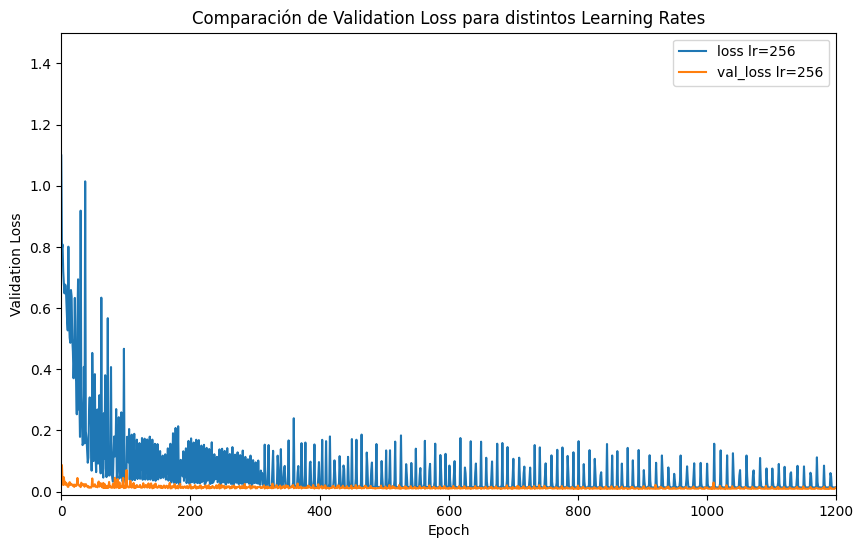

In [10]:
plt.figure(figsize=(10,6))
for batch, history in loss_histories.items():
    plt.plot(history['loss'], label=f'loss lr={batch}')
    plt.plot(history['val_loss'], label=f'val_loss lr={batch}')
plt.axis([0, ep, -0.01, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Comparación de Validation Loss para distintos Learning Rates')
plt.legend()
plt.show()

In [11]:
datos = model.predict_on_batch(inputsmodel) #Estudiar esto
aa= datos.tolist()
lista = []
for i in range(len(aa)):
    lista.append(aa[i][0])
df1 = pd.DataFrame()
df1['predicted'] = lista
df1

,predicted
0,5.008637
1,4.685480
2,4.347258
3,4.143886
4,4.044874
...,...
724,0.592391
725,0.624069
726,0.637533
727,0.647115


In [12]:
np.save('TrainRES_BS_'+str(0.001)+'_EPs'+str(ep)+'_VSplit'+str(pv)+
        '_BatchSz'+str(batch)+'.npy',np.array([history['val_loss'],history['loss']]))


np.save('TrainPREDS_BS_'+str(0.001)+'_EPs'+str(ep)+'_VSplit'+str(pv)+
        '_BatchSz'+str(batch)+'.npy',np.array([df['V'],lista]))

/tmp/ipykernel_92670/3160724708.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


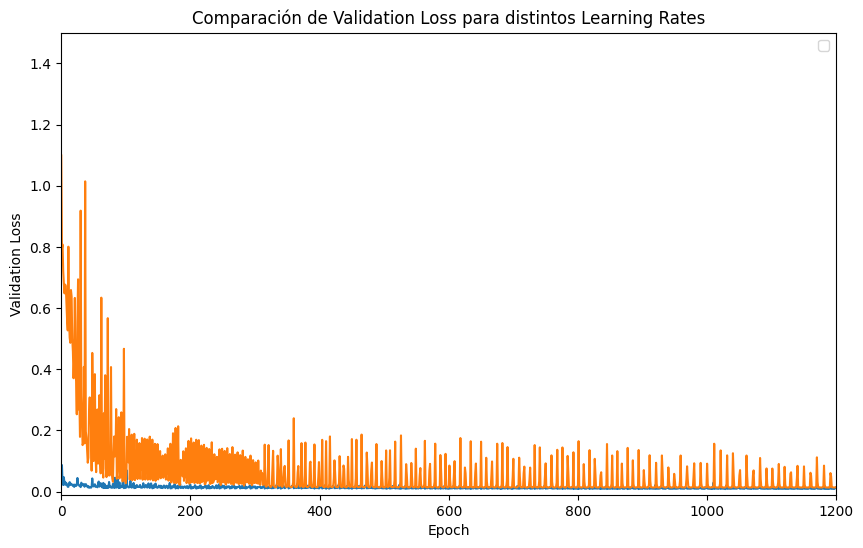

In [13]:
test = np.load('TrainRES_BS_0.001_EPs1200_VSplit0.2_BatchSz256.npy')

plt.figure(figsize=(10,6))
plt.plot(test[0,:])
plt.plot(test[1,:])
plt.axis([0, ep, -0.01, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Comparación de Validation Loss para distintos Learning Rates')
plt.legend()
plt.show()

In [14]:
test1 = np.load('TrainPREDS_BS_0.001_EPs1200_VSplit0.2_BatchSz256.npy')
test1.shape

(2, 729)

(np.float64(-0.1), np.float64(5.0), np.float64(-0.1), np.float64(5.0))

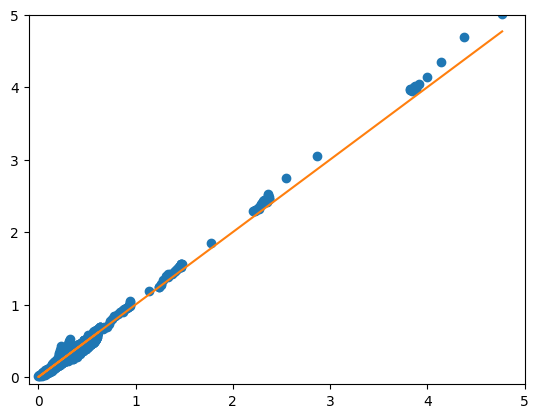

In [15]:
plt.plot(df['V'], df1['predicted'],'o')
plt.plot(df['V'], df['V'])
plt.axis([-0.1,5,-0.1,5])

# Recursos de utilidad
https://wandb.ai/ayush-thakur/dl-question-bank/reports/Input-Keras-Layer-Explanation-With-Code-Samples--VmlldzoyMDIzMDU#:~:text=a%20certain%20way.-,What%20Is%20Dim%20In%20A%20Keras%20Layer%3F,tensor%20like%20(3%2C).



# Que son las PINNs?
$\textit{Physics Informed neural networks}$ son redes neuronales que incluyen leyes fisicas para resolver un problema fisico, en la forma de ecuaciones diferenciales parciales adicionales al problema supervisado original.
En las PINNs se combinan el efecto de adherirse a una ecuacion fisica asi como tambien los conocimientos familiares de machine learning

## Como se usa una PINN?
Hacer uso de una PINN incluye anadir un residual en terminos de perdida

## Ecuacion de Burgers
Consideramos la ecuacion de Burgers como ejemplo. En una dimension, la ecuacion de Burgers junto con la condicion de frontera de Dirichlet es:

\begin{split}
  u_t + uu_x - (0.001/\pi)u_{xx}=0, \\
  x \in [-1,1],t\in [0,1], \\
  u(0,x)=-\sin(\pi x), \\
  u(t,-1)=u(t,1)=0
\end{split}

Definimos $f(t,x)$ como:
$$f:= u_t+u_x-(0.01/\pi)u_{xx} $$

Luego se aproxima $u(x,t)$ con una red neuronal profunda. Los parametros compartidos entre $u(t,x)$ y $f(t,x)$ se pueden aprender minimizando la perdida de error de minimos cuadrados:

\begin{split}
    MSE=MSE_u+MSE_f, \\
    MSE_u = {1\over{N_u}}\sum_{i=1}^{N_u}{|u(t_{iu},x_{iu})-u_i|^2}, \\
    MSE_f={1\over{N_f}}\sum_{i=1}^{N_f}{|f(t_{if},x_{if})|^2}
\end{split}

el loss $MSE_u$ corresponde al data inial y a las condiciones de frontera iniciales, mientras que $MSE_f$ refuerza la estructura impuesta por la ecuacion de Burgers en un set finito de punto de colocacion, esto actua como un termino residual.
Los puntos t,x junto con la u denotan el training data inicial y de frontera en $u(t,x)$. Los puntos t,x con f especifican los puntos de colocacion para $f(t,x)$

# WORKFLOW
La funcion morse tiene una forma $$D_O[1-\exp^{-\alpha_O(r_O -r_{eq_O})}]^2$$ para el enlace del oxigeno, y una forma $$D_S[1-\exp^{-\alpha_S(r_S -r_{eq_S})}]^2$$ para el enlace del azufre.

La forma de la ecuacion a agregar a la funcion perdida personalizada es del tipo: $$\underbrace{(\hat{y_i}-y_i)^2}_{\text{MSE}} + \underbrace{(\hat{y_i}-V(r_O,r_S))^2}_{\text{PINN MSE}}$$

Podemos hacer una interpolacion o una regresion unidimensional a una de las funciones morse
Esto es funcion morse + ruido
Morse 2-D